# Exercises

We are going to implement some functions inspired on the Assignments.

## Monte Carlo Simulation
Implement the function **EuropeanOptionMC** whose signature is defined below.

In [21]:
import numpy as np

def EuropeanOptionMC(forward, strike, discount_factor, time_to_maturity, volatility, number_of_samples, flag):
        
    # generate random vectors:
    zetas = np.random.randn(1,number_of_samples)
    
    # payoff vectors:
    payoff = forward*np.exp(-volatility**2/2*time_to_maturity + volatility*np.sqrt(time_to_maturity)*zetas)-strike
    
    # put or call:
    if flag == -1:
        payoff = -payoff
        
    # positive part of payoff:
    payoff = payoff.clip(0, np.inf)
    
    # compute price:
    price = discount_factor * np.mean(payoff)
    
    return price
    


## Self-exercise: Black & Scholes formula.

Let's do another exercise, and implement the standart B&S Pricing Formula:

In [12]:
import numpy as np

def EuropeanOptionBS(forward, strike, discount_factor, time_to_maturity, volatility, flag):
    
    from scipy.stats import norm
    
    # computation of d1 and d2:
    d1 = np.log(forward/strike)/np.sqrt(time_to_maturity*volatility**2) + 0.5*np.sqrt(time_to_maturity*volatility**2)
    
    d2 = d1 - np.sqrt(time_to_maturity*volatility**2)
    
    price = discount_factor * (forward * norm.cdf(d1) - strike* norm.cdf(d2))
    
    # tbd: implement the put price:
    return price
    

Let's try the implemented functions (as in Assignment 1):

In [19]:
import numpy as np

# parameters
strike = 1
volatility = 0.2
ir = 0.03
TTM = 1
flag = 0

# computation of forward and discount factor:
forward = np.exp(TTM*ir)
discount = 1/forward

priceBS = EuropeanOptionBS(forward, strike, discount, TTM, volatility, flag)

# price with Monte Carlo:
M = 1000000
priceMC = EuropeanOptionMC(forward, strike, discount, TTM, volatility, M, flag)


print("Black & Scholes price: ", priceBS)
print("Monte Carlo price: ", priceMC)

Black & Scholes price:  0.09413403383853029
Monte Carlo price:  0.0942805511357095


In [23]:
# make the tests pass

from importlib import reload
from test_helper import run_test
import tests

reload(tests)
run_test(tests.EuropeanOptionMCTest('test_call', EuropeanOptionMC))
run_test(tests.EuropeanOptionMCTest('test_put', EuropeanOptionMC))

.
----------------------------------------------------------------------
Ran 1 test in 0.002s

OK
.
----------------------------------------------------------------------
Ran 1 test in 0.002s

OK


## Bootstrap Preprocessing
First lets implement a function that reads the swap rates from the file **MktData_CurveBootstrap.xls**.

In [30]:
import pandas as pd

def ReadSwapRates(file, sheet, fromRow, numberOfRows, columnRange):
    swaps = pd.read_excel(file, sheet_name = sheet, index_col = 0, skiprows = fromRow, usecols = columnRange)
    swaps = swaps[:numberOfRows]
    
    return swaps
    

Let's test the function:

In [38]:
swap_rates = ReadSwapRates('MktData_CurveBootstrap.xls',sheet = 0, fromRow = 37, numberOfRows = 50, columnRange = 'D:F')

print(swap_rates)

#print(swap_rates.axes)
swap_rates_numpy = swap_rates.to_numpy()
print(swap_rates)

                 BID       ASK
Swap                          
2009-02-19  4.120000  4.140000
2010-02-19  3.861000  3.882000
2011-02-21  3.882000  3.902000
2012-02-20  3.948000  3.968000
2013-02-19  4.032000  4.052000
2014-02-19  4.117000  4.137000
2015-02-19  4.202000  4.222000
2016-02-19  4.283000  4.303000
2017-02-20  4.357000  4.377000
2018-02-19  4.424000  4.444000
2019-02-19  4.473000  4.513000
2020-02-19  4.524000  4.564000
2021-02-19  4.565557  4.609897
2022-02-21  4.603391  4.646468
2023-02-20  4.636000  4.676000
2024-02-19  4.662910  4.701032
2025-02-19  4.684683  4.722343
2026-02-19  4.701897  4.740038
2027-02-19  4.715393  4.754474
2028-02-21  4.726000  4.766000
2029-02-19  4.734259  4.774764
2030-02-19  4.740543  4.781173
2031-02-19  4.744987  4.785489
2032-02-19  4.747751  4.788001
2033-02-21  4.749000  4.789000
2034-02-20  4.748885  4.788744
2035-02-19  4.747625  4.787446
2036-02-19  4.745420  4.785272
2037-02-19  4.742470  4.782392
2038-02-19  4.739000  4.779000
2039-02-

In [36]:
# make the tests pass

from importlib import reload
from test_helper import run_test
import tests

reload(tests)
run_test(tests.ReadSwapRatesTest('test_header', ReadSwapRates))
run_test(tests.ReadSwapRatesTest('test_number_of_rows', ReadSwapRates))
run_test(tests.ReadSwapRatesTest('test_dates', ReadSwapRates))
run_test(tests.ReadSwapRatesTest('test_bids', ReadSwapRates))
run_test(tests.ReadSwapRatesTest('test_asks', ReadSwapRates))


.
----------------------------------------------------------------------
Ran 1 test in 0.030s

OK
.
----------------------------------------------------------------------
Ran 1 test in 0.027s

OK
.
----------------------------------------------------------------------
Ran 1 test in 0.036s

OK
.
----------------------------------------------------------------------
Ran 1 test in 0.039s

OK
.
----------------------------------------------------------------------
Ran 1 test in 0.030s

OK


Now lets extract the dates and calculate the mid rates.

In [39]:
import numpy as np
import pandas as pd

def ExtractDatesAndMidRates(swap_rates):
    # swap_rates is the DataFrame returned by ReadSwapRates
    # to return more than one result in Python simply separate them by comma, e.g. return dates, mid_rates
    # return a plain Python list for the dates and a NumPy array for the rates
    
    dates = swap_rates.axes[0].tolist()
    bids = swap_rates['BID'].to_numpy()
    asks = swap_rates['ASK'].to_numpy()
    
    # alternative: bids = np.array(swap_rates['BID'])
    
    mid_rates = (bids + asks)/2
    return dates, mid_rates


# let's try this:
print(ExtractDatesAndMidRates (swap_rates))

([Timestamp('2009-02-19 00:00:00'), Timestamp('2010-02-19 00:00:00'), Timestamp('2011-02-21 00:00:00'), Timestamp('2012-02-20 00:00:00'), Timestamp('2013-02-19 00:00:00'), Timestamp('2014-02-19 00:00:00'), Timestamp('2015-02-19 00:00:00'), Timestamp('2016-02-19 00:00:00'), Timestamp('2017-02-20 00:00:00'), Timestamp('2018-02-19 00:00:00'), Timestamp('2019-02-19 00:00:00'), Timestamp('2020-02-19 00:00:00'), Timestamp('2021-02-19 00:00:00'), Timestamp('2022-02-21 00:00:00'), Timestamp('2023-02-20 00:00:00'), Timestamp('2024-02-19 00:00:00'), Timestamp('2025-02-19 00:00:00'), Timestamp('2026-02-19 00:00:00'), Timestamp('2027-02-19 00:00:00'), Timestamp('2028-02-21 00:00:00'), Timestamp('2029-02-19 00:00:00'), Timestamp('2030-02-19 00:00:00'), Timestamp('2031-02-19 00:00:00'), Timestamp('2032-02-19 00:00:00'), Timestamp('2033-02-21 00:00:00'), Timestamp('2034-02-20 00:00:00'), Timestamp('2035-02-19 00:00:00'), Timestamp('2036-02-19 00:00:00'), Timestamp('2037-02-19 00:00:00'), Timestamp('2

In [40]:
# make the tests pass

from importlib import reload
from test_helper import run_test
import tests

reload(tests)
run_test(tests.ExtractDatesAndMidRatesTest('test_dates', ExtractDatesAndMidRates))
run_test(tests.ExtractDatesAndMidRatesTest('test_mid_rates', ExtractDatesAndMidRates))

.
----------------------------------------------------------------------
Ran 1 test in 0.003s

OK
.
----------------------------------------------------------------------
Ran 1 test in 0.005s

OK


## Plotting
In this exercise we are going to use the __[matplotlib](https://matplotlib.org/)__ library.

Given the following survival probability function at time $t$: $ P(t,T) = e^{-\lambda(T-t)}$ where $\lambda = 4.10^{-3}$ and $T > t$,
* Simulate $10^4$ times the default time $\tau$
* Calculate the empirical survival probabilities up to 30 years from these samples, use a 1 year granularity
* Plot in a loglinear scale both the empirical survival probabilities and the theoretical survival probabilities


First lets implement a function to calculate the empirical survival probabilities. Some functions that may come handy: __[numpy.floor](https://docs.scipy.org/doc/numpy/reference/generated/numpy.floor.html)__, __[numpy.count_nonzero](https://docs.scipy.org/doc/numpy/reference/generated/numpy.count_nonzero.html)__, and __[numpy.cumsum](https://docs.scipy.org/doc/numpy/reference/generated/numpy.cumsum.html)__,

In [20]:
import numpy as np

def CalculateEmpiricalSurvivalProbabilities(number_of_samples, lambdas, last_year):
    uniforms = np.random.rand(number_of_samples,1)
    default_years = np.floor(-1/lambdas*np.log(uniforms))
    # let's count the defaults each year:
    defaults_by_year = [np.count_nonzero(default_years == n) for n in np.arange(0,last_year)]
    #print(defaults_by_year)
    #print(np.cumsum(defaults_by_year))
    return (number_of_samples - np.cumsum(defaults_by_year))/number_of_samples
    

Let's try the function:

In [21]:
CalculateEmpiricalSurvivalProbabilities(10**4, 0.04, 30)

array([0.9594, 0.9248, 0.8881, 0.8574, 0.8233, 0.7905, 0.761 , 0.7304,
       0.7036, 0.6779, 0.6545, 0.6289, 0.6047, 0.5796, 0.5542, 0.5323,
       0.5105, 0.4905, 0.4719, 0.4521, 0.4345, 0.4182, 0.4021, 0.3895,
       0.3762, 0.3619, 0.348 , 0.3336, 0.3187, 0.3059])

In [22]:
# make the tests pass

from importlib import reload
from test_helper import run_test
import tests

reload(tests)
run_test(tests.CalculateEmpiricalSurvivalProbabilitiesTest('test_size_must_be_30', CalculateEmpiricalSurvivalProbabilities))
run_test(tests.CalculateEmpiricalSurvivalProbabilitiesTest('test_probabilities', CalculateEmpiricalSurvivalProbabilities))

.
----------------------------------------------------------------------
Ran 1 test in 0.006s

OK
.
----------------------------------------------------------------------
Ran 1 test in 0.002s

OK


Now let's plot our results. Check the __[examples](https://matplotlib.org/tutorials/introductory/sample_plots.html)__ provided in the matplotlib page.

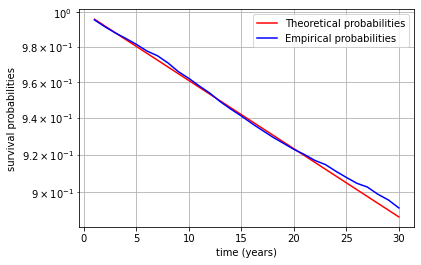

In [27]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import solutions

# Data for plotting
lambdas = 0.004
number_of_samples = 10**4
last_year = 30
times = np.arange(1, last_year + 1)
theoretical_probabilities = np.exp(-lambdas*times)
empirical_probabilities = solutions.CalculateEmpiricalSurvivalProbabilities(number_of_samples, lambdas, last_year)

# get handle for the plot
fig, ax = plt.subplots()

# plot theoretical_probabilities and empirical_probabilities
ax.plot(times, theoretical_probabilities, color = 'red',label='Theoretical probabilities')
ax.plot(times, empirical_probabilities, color = 'blue',label='Empirical probabilities')
ax.set_yscale('log')

# set labels
ax.set(xlabel='time (years)', ylabel='survival probabilities')
ax.legend()
ax.grid(which='both')

# show plot
plt.show()